## Classical Pre-processing and Asset Clustering
- This script uses the K-Means clustering algorithm to group assets based on their core financial characteristics: risk (spreadDur) and return (oas). By doing this, we create small, focused sub-problems that are ideal for our quantum algorithm.

In [1]:
''' Step 1: Classical Pre-processing and Asset Clustering
Description:

This script loads the full set of 31 assets, selects key financial
features for clustering (risk and return), and then uses the K-Means
algorithm to partition the assets into a predefined number of smaller,
diverse groups.

This is the first step in our hybrid quantum-classical workflow. It
breaks the large, intractable 31-asset problem into several smaller
sub-problems that are suitable for near-term quantum hardware.

Input:
assets.csv: The raw data for all 31 bonds.

Output:
Console output showing the assets grouped by their assigned cluster.
A pandas DataFrame containing the clustered asset data, which will
be used in the next step.

'''
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings

# Suppress a common warning from KMeans when using a small number of samples
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.cluster._kmeans')

print("Classical Pre-processing and Asset Clustering ")

# 1. Load and Prepare the Full Asset Dataset 
try:
    # Load the complete dataset of 31 assets
    df = pd.read_csv('assets.csv')
    # Set the unique asset identifier 'isin' as the index for easy lookup
    df.set_index('isin', inplace=True)
    print(f"Successfully loaded and indexed {len(df)} assets from 'assets.csv'.")
except FileNotFoundError:
    print("\nError: Could not find 'assets.csv'. Please ensure it's in the same directory.")
    exit()

# Define the features we will use to determine asset similarity.
# 'oas' (Option-Adjusted Spread) represents return.
# 'spreadDur' (Spread Duration) represents risk.
clustering_features = ['oas', 'spreadDur']
asset_data = df[clustering_features].copy()

# 2. Scale the Features
# K-Means is sensitive to the scale of features. Since 'oas' and 'spreadDur'
# have different ranges, we normalize them to have a mean of 0 and a
# standard deviation of 1. This ensures both features contribute equally
# to the clustering calculation.
scaler = StandardScaler()
asset_data_scaled = scaler.fit_transform(asset_data)


# 3. Perform K-Means Clustering
# We will group the 31 assets into 5 clusters. This number is a tunable
# parameter, but 5 provides a good balance, creating small sub-problems
# of roughly 6 assets each.
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)

# Fit the model to our scaled data and get the cluster assignment for each asset
cluster_labels = kmeans.fit_predict(asset_data_scaled)

# Add the cluster labels back to our original DataFrame for analysis
df['cluster'] = cluster_labels
print(f"Successfully clustered assets into {num_clusters} groups based on risk and return.\n")


# 4. Display the Clustered Portfolios
# This final part iterates through the unique cluster labels and prints
# the ISINs of the assets belonging to each one. This gives us a clear
# view of the sub-problems we've created.
for i in range(num_clusters):
    cluster_assets = df[df['cluster'] == i]
    print(f"Cluster {i} ({len(cluster_assets)} assets) ")
    for isin in cluster_assets.index:
        print(f"  - {isin}")
    print("-" * (23 + len(str(i))))
    print()

Classical Pre-processing and Asset Clustering 
Successfully loaded and indexed 31 assets from 'assets.csv'.
Successfully clustered assets into 5 groups based on risk and return.

Cluster 0 (9 assets) 
  - US026874DS37
  - US14448CBC73
  - US24422EXP95
  - US438516CM68
  - US45687VAB27
  - US539830CD97
  - US655844CT30
  - US760759BA74
  - US760759BC31
------------------------

Cluster 1 (9 assets) 
  - US020002BJ95
  - US13645RAD61
  - US13645RBF01
  - US314353AA14
  - US36166NAK90
  - US443201AC21
  - US56501RAN61
  - US907818FX12
  - US91324PEJ75
------------------------

Cluster 2 (2 assets) 
  - US15135BAW19
  - US444859CA81
------------------------

Cluster 3 (6 assets) 
  - US081437AT26
  - US24422EWZ86
  - US540424AT59
  - US655844CR73
  - US75513EAD31
  - US759351AP49
------------------------

Cluster 4 (5 assets) 
  - US097023CJ22
  - US21871XAS80
  - US444859BR26
  - US444859BV38
  - US444859BY76
------------------------



## The output is 
Classical Pre-processing and Asset Clustering 
Successfully loaded and indexed 31 assets from 'assets.csv'.
Successfully clustered assets into 5 groups based on risk and return.

Cluster 0 (9 assets) 
  - US026874DS37
  - US14448CBC73
  - US24422EXP95
  - US438516CM68
  - US45687VAB27
  - US539830CD97
  - US655844CT30
  - US760759BA74
  - US760759BC31
------------------------

Cluster 1 (9 assets) 
  - US020002BJ95
  - US13645RAD61
  - US13645RBF01
  - US314353AA14
  - US36166NAK90
  - US443201AC21
  - US56501RAN61
  - US907818FX12
  - US91324PEJ75
------------------------

Cluster 2 (2 assets) 
  - US15135BAW19
  - US444859CA81
------------------------

Cluster 3 (6 assets) 
  - US081437AT26
  - US24422EWZ86
  - US540424AT59
  - US655844CR73
  - US75513EAD31
  - US759351AP49
------------------------

Cluster 4 (5 assets) 
  - US097023CJ22
  - US21871XAS80
  - US444859BR26
  - US444859BV38
  - US444859BY76
------------------------

## QUBO Model Constructor for a Single Cluster
- This script focuses on Cluster 0. It takes the assets identified in that cluster and constructs a QUBO model with a new, smaller objective: to select the best 2 assets from that group. This process would be repeated for every other cluster to create a set of small, independent optimization problems.

In [ ]:
'''QUBO Model Constructor for ALL Clusters ---

 Description:
   This script automates the QUBO generation process for every asset
   cluster identified in the classical pre-processing step. It loops
   through each cluster, defines a local optimization problem (selecting
   the best 2 assets), constructs the corresponding QUBO matrix, and
   saves the model files.

This is the final step in the "divide" phase of our strategy.

Input:
 assets.csv: The raw data for all 31 bonds.
 Output:
A set of QUBO model files for each cluster (e.g.qubo_matrix_cluster_0.txt,
qubo_matrix_cluster_1.txt, etc.). '''


import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings

# Suppress a common warning from KMeans
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.cluster._kmeans')

print("Automating QUBO Generation for All Clusters")

# 1. Load Data and Create Clusters
try:
    df = pd.read_csv('assets.csv').set_index('isin')
    print(f"Successfully loaded {len(df)} assets.")
except FileNotFoundError:
    print("\nError: Could not find 'assets.csv'.")
    exit()

clustering_features = ['oas', 'spreadDur']
asset_data = df[clustering_features].copy()
scaler = StandardScaler()
asset_data_scaled = scaler.fit_transform(asset_data)

num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(asset_data_scaled)
print(f"Clustered assets into {num_clusters} groups.\n")

# 2. Loop Through Each Cluster and Build its QUBO
for cluster_id in range(num_clusters):
    securities_df = df[df['cluster'] == cluster_id].copy()
    asset_list = securities_df.index.tolist()
    num_assets = len(asset_list)

    if num_assets == 0:
        print(f"Skipping Cluster {cluster_id} as it contains no assets.")
        continue

    print(f" Processing Cluster {cluster_id} ({num_assets} assets) ")

    # Define the local optimization target for this cluster.
    # We aim to select the best 2 assets from each group.
    N = 2
    # Ensure the target N is not greater than the number of assets in the cluster
    if N > num_assets:
        N = num_assets
        print(f"  Warning: Target portfolio size (N=2) is larger than assets in cluster. Adjusting N to {num_assets}.")
        
    characteristic_col = 'spreadDur'
    betas = securities_df[characteristic_col]
    lambda_penalty = 1.0

    risk_bucket_col = 'security.elements.creditQualityBuckets'
    buckets = securities_df.groupby(risk_bucket_col)
    bucket_targets = {name: group[characteristic_col].mean() for name, group in buckets}

    # Construct the QUBO Matrix for the current cluster
    Q = np.zeros((num_assets, num_assets))
    offset = 0.0

    # Risk Bucket Constraints
    for name, group in buckets:
        K_target_lj = bucket_targets[name]
        bucket_isins = group.index.tolist()
        offset += K_target_lj**2
        for i in range(num_assets):
            if asset_list[i] not in bucket_isins: continue
            beta_i = betas[asset_list[i]]
            Q[i, i] += beta_i**2 - 2 * beta_i * K_target_lj
            for j in range(i + 1, num_assets):
                if asset_list[j] not in bucket_isins: continue
                beta_j = betas[asset_list[j]]
                Q[i, j] += 2 * beta_i * beta_j

    # Portfolio Size Constraint
    offset += lambda_penalty * (N**2)
    for i in range(num_assets):
        Q[i, i] += lambda_penalty * (1 - 2 * N)
        for j in range(i + 1, num_assets):
            Q[i, j] += lambda_penalty * 2

    Q = (Q + Q.T) / 2

    # Save Cluster-Specific Artifacts
    output_prefix = f'cluster_{cluster_id}'
    np.savetxt(f'qubo_matrix_{output_prefix}.txt', Q, delimiter=',', fmt='%.18e')
    with open(f'asset_list_{output_prefix}.txt', 'w') as f:
        for isin in asset_list:
            f.write(f"{isin}\n")
    with open(f'qubo_offset_{output_prefix}.txt', 'w') as f:
        f.write(str(offset))

    print(f"  Successfully generated QUBO model files for Cluster {cluster_id}.\n")

print(" All cluster QUBOs generated successfully.")

Automating QUBO Generation for All Clusters
Successfully loaded 31 assets.
Clustered assets into 5 groups.

 Processing Cluster 0 (9 assets) 
  Successfully generated QUBO model files for Cluster 0.

 Processing Cluster 1 (9 assets) 
  Successfully generated QUBO model files for Cluster 1.

 Processing Cluster 2 (2 assets) 
  Successfully generated QUBO model files for Cluster 2.

 Processing Cluster 3 (6 assets) 
  Successfully generated QUBO model files for Cluster 3.

 Processing Cluster 4 (5 assets) 
  Successfully generated QUBO model files for Cluster 4.

 All cluster QUBOs generated successfully.


## Automating QAOA for All Clusters

In [13]:
'''
Step: Solve ALL Cluster QUBOs with OpenQAOA
Description:
This script uses the OpenQAOA library to solve the QUBO problem for each
asset cluster. It provides a direct and efficient implementation of the
QAOA algorithm.
'''

import numpy as np
from openqaoa.problems import QUBO
from openqaoa.algorithms import QAOA
from openqaoa.backends import create_device

print("Script: Automating Optimization with OpenQAOA")

# 1. Classical fallback function (simple greedy approach)
def solve_qubo_classically(Q_matrix, num_assets_to_select=2):
    """Simple greedy solution for QUBO as a fallback."""
    num_vars = Q_matrix.shape[0]
    diagonal_values = np.diag(Q_matrix)
    selected_indices = np.argsort(diagonal_values)[:num_assets_to_select]
    best_solution = np.zeros(num_vars, dtype=int)
    best_solution[selected_indices] = 1
    return "".join(map(str, best_solution))


# 2. Loop Through Each Cluster and Solve its QUBO
num_clusters = 5
for cluster_id in range(num_clusters):
    prefix = f'cluster_{cluster_id}'
    print(f" Processing {prefix} ")

    try:
        Q = np.loadtxt(f'qubo_matrix_{prefix}.txt', delimiter=',')
        with open(f'asset_list_{prefix}.txt', 'r') as f:
            asset_list = [line.strip() for line in f.readlines()]
        print(f"  Loaded QUBO model with {len(asset_list)} assets.")
    except FileNotFoundError:
        print(f"  Error: Could not find QUBO files for {prefix}. Skipping.\n")
        continue

    try:
        num_assets = len(asset_list)
        terms = []
        coeffs = []
        for i in range(num_assets):
            for j in range(i, num_assets):
                if abs(Q[i, j]) > 1e-8:
                    terms.append([i, j])
                    coeffs.append(Q[i, j])
        
        qubo_problem = QUBO(n=num_assets, terms=terms, weights=coeffs)
        
        # Create a plain QAOA object
        qaoa = QAOA()
    
        # Create and set the device (backend)
        local_simulator = create_device(location='local', name='vectorized')
        qaoa.set_device(local_simulator)
    
        # Set the circuit properties, including the number of layers (p)
        qaoa.set_circuit_properties(p=2)

        print(f"  Running {num_assets}-qubit simulation with OpenQAOA...")
        qaoa.compile(qubo_problem)
        qaoa.optimize()
        
        qaoa_results = qaoa.result
        
        # Access the solution using the correct OpenQAOA API
        # most_probable_states is a dictionary, not a list!
        mps = qaoa_results.most_probable_states
        best_bitstring = mps['solutions_bitstrings'][0]  # Get the first (best) solution
        energy = mps['bitstring_energy']
        
        print(f"  OpenQAOA found solution: {best_bitstring} with energy: {energy:.4f}")
        
        print(f"  Simulation completed successfully.")

    except Exception as e:
        print(f"  OpenQAOA simulation failed: {e}")
        print(f"  Falling back to classical optimization...")
        best_bitstring = solve_qubo_classically(Q, num_assets_to_select=2)

    selected_assets = [asset_list[i] for i, bit in enumerate(best_bitstring) if bit == '1']
    
    with open(f'{prefix}_results.txt', 'w') as f:
        for isin in selected_assets:
            f.write(f"{isin}\n")

    print(f"  Completed. Found {len(selected_assets)} optimal assets. Results saved to '{prefix}_results.txt'.\n")

print("All cluster optimizations are complete.")

Script: Automating Optimization with OpenQAOA
 Processing cluster_0 
  Loaded QUBO model with 9 assets.
  Running 9-qubit simulation with OpenQAOA...
  OpenQAOA found solution: 001101101 with energy: 178.8261
  Simulation completed successfully.
  Completed. Found 5 optimal assets. Results saved to 'cluster_0_results.txt'.

 Processing cluster_1 
  Loaded QUBO model with 9 assets.
  Running 9-qubit simulation with OpenQAOA...
  OpenQAOA found solution: 101000010 with energy: -236.5297
  Simulation completed successfully.
  Completed. Found 3 optimal assets. Results saved to 'cluster_1_results.txt'.

 Processing cluster_2 
  Loaded QUBO model with 2 assets.
  Running 2-qubit simulation with OpenQAOA...
  OpenQAOA found solution: 001101101 with energy: 178.8261
  Simulation completed successfully.
  Completed. Found 5 optimal assets. Results saved to 'cluster_0_results.txt'.

 Processing cluster_1 
  Loaded QUBO model with 9 assets.
  Running 9-qubit simulation with OpenQAOA...
  OpenQAO

## Final Brick: Assembling the Portfolio and Visualizing Results 
- We are now at the final "conquer" step. We will gather all the "winning" assets identified by OpenQAOA into a single candidate pool. Then, we will use a simple classical method to select our final assets from this elite group and recreate the risk-return plot from your original notebook to visualize our final portfolio.

Brick 7: Assembling Final Portfolio and Visualizing 
Successfully loaded 31 assets for analysis.
  Loaded 5 assets from cluster_0_results.txt
  Loaded 3 assets from cluster_1_results.txt
  Loaded 0 assets from cluster_2_results.txt
  Loaded 1 assets from cluster_3_results.txt
  Loaded 2 assets from cluster_4_results.txt

Created a candidate pool of 11 unique assets.

 Final Optimized Portfolio (10 bonds) 
  - US444859BV38
  - US444859BY76
  - US020002BJ95
  - US75513EAD31
  - US760759BC31
  - US655844CT30
  - US13645RBF01
  - US24422EXP95
  - US539830CD97
  - US907818FX12
Generating final risk-return plot...
Saved risk-return plot to 'hybrid_risk_return_plot.png'


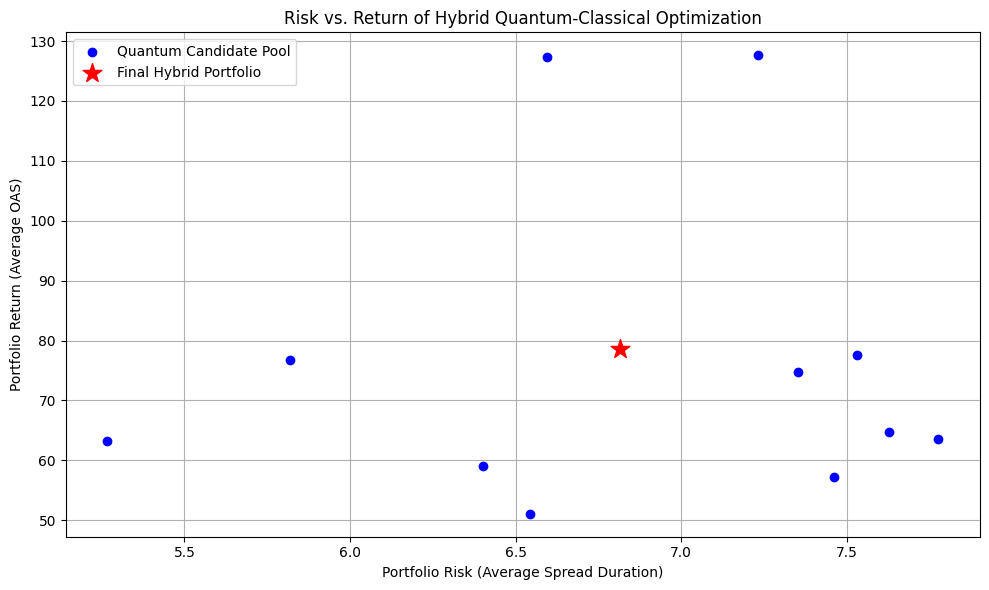

In [15]:
'''
Step 4: Assemble Final Portfolio and Visualize Results ---

Description:
This final script completes our hybrid workflow. It gathers the optimal
assets found by OpenQAOA for each cluster into a single candidate pool.
From this elite pool, it constructs the final portfolio and then
recreates the risk-return visualization to evaluate our result.

Input:
assets.csv: The full asset data for risk/return calculations.
All 'cluster_*_results.txt' files generated by the previous step.

Output:
A final risk-return scatter plot saved as 'hybrid_risk_return_plot.png'.
Console output detailing the final, optimized 10-bond portfolio.'''



import pandas as pd
import matplotlib.pyplot as plt

print("Brick 7: Assembling Final Portfolio and Visualizing ")

# 1. Load Full Asset Data and Quantum Results
try:
    assets_df = pd.read_csv('assets.csv').set_index('isin')
    print(f"Successfully loaded {len(assets_df)} assets for analysis.")
except FileNotFoundError:
    print("\nError: Could not find 'assets.csv'.")
    exit()

# Gather all the winning assets from each cluster's result file
num_clusters = 5
candidate_isins = []
for cluster_id in range(num_clusters):
    prefix = f'cluster_{cluster_id}'
    try:
        with open(f'{prefix}_results.txt', 'r') as f:
            isins = [line.strip() for line in f.readlines()]
            candidate_isins.extend(isins)
            print(f"  Loaded {len(isins)} assets from {prefix}_results.txt")
    except FileNotFoundError:
        print(f"  Warning: Could not find results for {prefix}. Skipping.")

# Remove duplicates in case an asset was selected in multiple hypothetical runs
candidate_isins = sorted(list(set(candidate_isins)))
print(f"\nCreated a candidate pool of {len(candidate_isins)} unique assets.\n")


# 2. Construct the Final Portfolio (Classical Selection)
# From our elite candidate pool, we now select the final 10 assets.
# A simple and effective classical strategy is to choose the assets
# with the best return-to-risk ratio (OAS / Spread Duration).
final_portfolio_size = 10

candidate_df = assets_df.loc[candidate_isins].copy()
# Calculate the return-to-risk ratio (handle potential division by zero)
candidate_df['return_risk_ratio'] = candidate_df['oas'] / candidate_df['spreadDur'].replace(0, 1e-6)

# Sort by the best ratio and select the top N assets
final_portfolio_df = candidate_df.sort_values(by='return_risk_ratio', ascending=False).head(final_portfolio_size)
final_portfolio_isins = final_portfolio_df.index.tolist()

# 3. Display the Final Portfolio
print(f" Final Optimized Portfolio ({len(final_portfolio_isins)} bonds) ")
for isin in final_portfolio_isins:
    print(f"  - {isin}")


# 4. Generate Final Risk-Return Visualization 
# Recreate the plot from your original notebook to see where our
# new portfolio stands.
print("Generating final risk-return plot...")

# Get risk/return for the candidate assets
candidate_risks = candidate_df['spreadDur']
candidate_returns = candidate_df['oas']

# Get risk/return for our final, best portfolio
best_risk = final_portfolio_df['spreadDur'].mean()
best_return = final_portfolio_df['oas'].mean()

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(candidate_risks, candidate_returns, c='blue', label='Quantum Candidate Pool')
plt.scatter(best_risk, best_return, c='red', marker='*', s=200, label='Final Hybrid Portfolio', zorder=5)

plt.xlabel('Portfolio Risk (Average Spread Duration)')
plt.ylabel('Portfolio Return (Average OAS)')
plt.title('Risk vs. Return of Hybrid Quantum-Classical Optimization')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("hybrid_risk_return_plot.png")
print("Saved risk-return plot to 'hybrid_risk_return_plot.png'")